# Focus: Radius

Initial standard steps

In [1]:
import kagglehub
import pandas as pd # to work with dataframes, manipulate data (panel data)
import matplotlib.pyplot as plt # viz library
import seaborn as sns # HD viz library
import numpy as np # to work with numbers (numerical python)
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from scipy.stats import pearsonr

%matplotlib inline
pd.set_option('display.max_columns', None)

data = pd.read_csv(r'cleaned_data.csv')
df = data.copy()


c:\ProgramData\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Specifying only radius related columns

In [2]:
df_rad = df[['id', 'diagnosis','radius_mean', 'radius_se', 'radius_worst' ]]

### Defining a new value column

Idea: Add a new value for the difference between mean radius and radius at worst to explore possible correlation focusing the change of size

In [3]:
# defining a new measure for the difference between the mean and the worst radiuses
df_rad = df_rad.assign( radius_diff = lambda x: (x['radius_worst'] - x['radius_mean'] ))
df_rad

,id,diagnosis,radius_mean,radius_se,radius_worst,radius_diff
0,842302,M,17.99,1.0950,25.380,7.390
1,842517,M,20.57,0.5435,24.990,4.420
2,84300903,M,19.69,0.7456,23.570,3.880
3,84348301,M,11.42,0.4956,14.910,3.490
4,84358402,M,20.29,0.7572,22.540,2.250
...,...,...,...,...,...,...
564,926424,M,21.56,1.1760,25.450,3.890
565,926682,M,20.13,0.7655,23.690,3.560
566,926954,M,16.60,0.4564,18.980,2.380
567,927241,M,20.60,0.7260,25.740,5.140


In [4]:
# filtering the DataFrame by diagnosis
df_M = df_rad[df_rad['diagnosis'] == 'M']
df_B = df_rad[df_rad['diagnosis'] == 'B']

### Radius histograms and overview

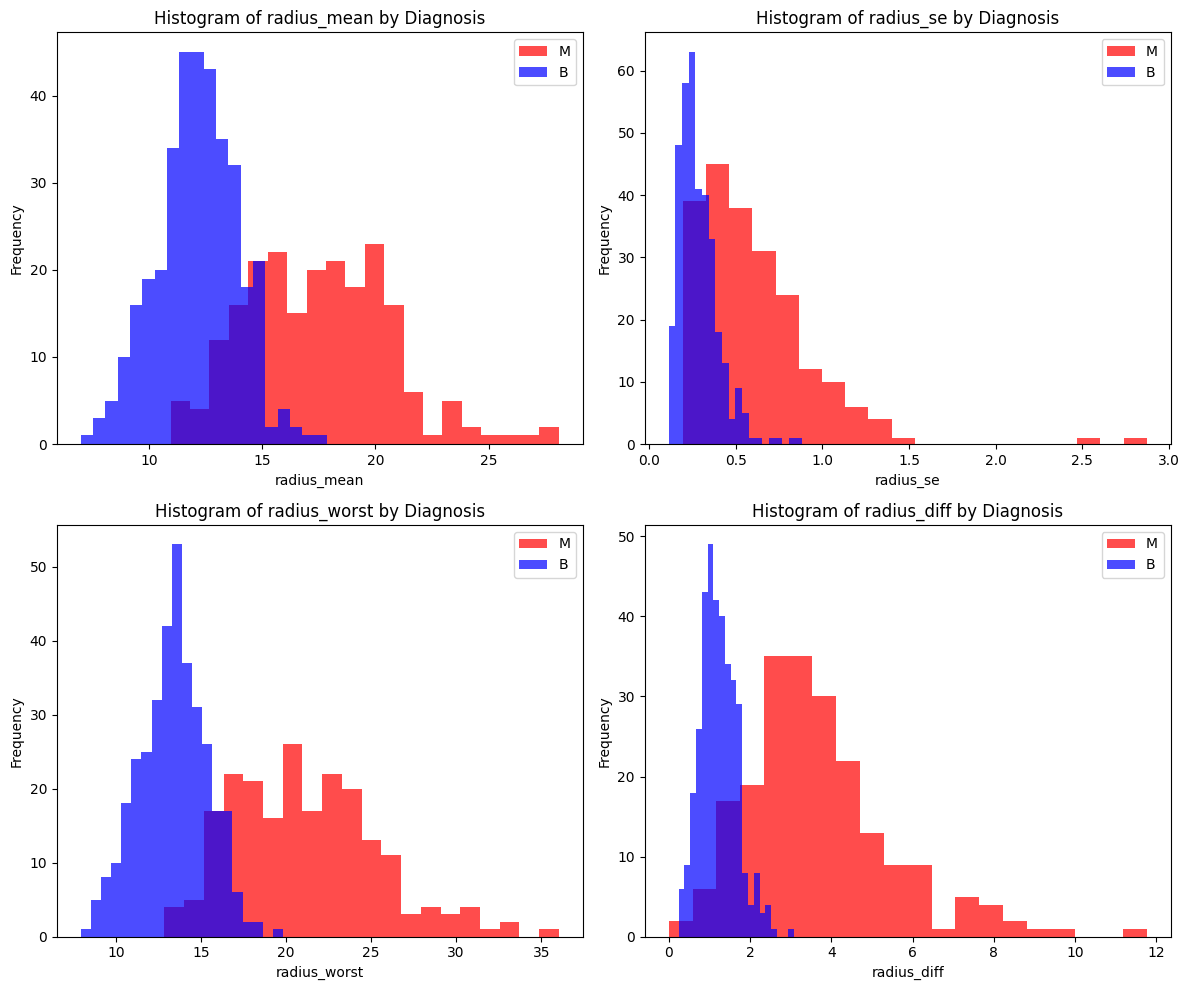

In [5]:
# list of radius variables to compare
radius_vars = ['radius_mean', 'radius_se', 'radius_worst', 'radius_diff']

# 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# loop through each texture variable and plot overlapping histograms for "M" and "B"
for i, var in enumerate(radius_vars):
    ax = axes[i // 2, i % 2]
    # filtering data by diagnosis
    data_M = df_rad[df_rad['diagnosis'] == 'M'][var]
    data_B = df_rad[df_rad['diagnosis'] == 'B'][var]
    
    # plot overlapping histograms with same style and colors:
    # diagnosis M in red and diagnosis B in blue, with alpha=0.7
    ax.hist(data_M, bins=20, alpha=0.7, label='M', color='red')
    ax.hist(data_B, bins=20, alpha=0.7, label='B', color='blue')
    
    ax.set_title(f"Histogram of {var} by Diagnosis")
    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.savefig('plots/histo_radius.png')
plt.show()


### Closer look at the overlapping regions

C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7284\747827104.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df_overlap.groupby(var + '_bin')['diagnosis'].count()
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7284\747827104.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_cancer = df_overlap.groupby(var + '_bin')['diagnosis'].apply(lambda x: (x == 'M').sum() / len(x))
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7284\747827104.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curre

radius_mean_bin
(10.949, 11.64]    0.054545
(11.64, 12.33]     0.050000
(12.33, 13.02]     0.111111
(13.02, 13.71]     0.196429
(13.71, 14.4]      0.333333
(14.4, 15.09]      0.377778
(15.09, 15.78]     0.814815
(15.78, 16.47]     0.823529
(16.47, 17.16]     0.846154
(17.16, 17.85]     0.933333
Name: diagnosis, dtype: float64
radius_se_bin
(0.193, 0.263]    0.153846
(0.263, 0.331]    0.227273
(0.331, 0.4]      0.232877
(0.4, 0.469]      0.557692
(0.469, 0.537]    0.600000
(0.537, 0.606]    0.793103
(0.606, 0.675]    0.941176
(0.675, 0.744]    0.857143
(0.744, 0.812]    1.000000
(0.812, 0.881]    0.833333
Name: diagnosis, dtype: float64
radius_worst_bin
(12.839, 13.538]    0.047619
(13.538, 14.236]    0.020408
(14.236, 14.934]    0.050000
(14.934, 15.632]    0.186047
(15.632, 16.33]     0.406250
(16.33, 17.028]     0.392857
(17.028, 17.726]    0.700000
(17.726, 18.424]    0.866667
(18.424, 19.122]    1.000000
(19.122, 19.82]     0.923077
Name: diagnosis, dtype: float64
radius_diff_bin
(

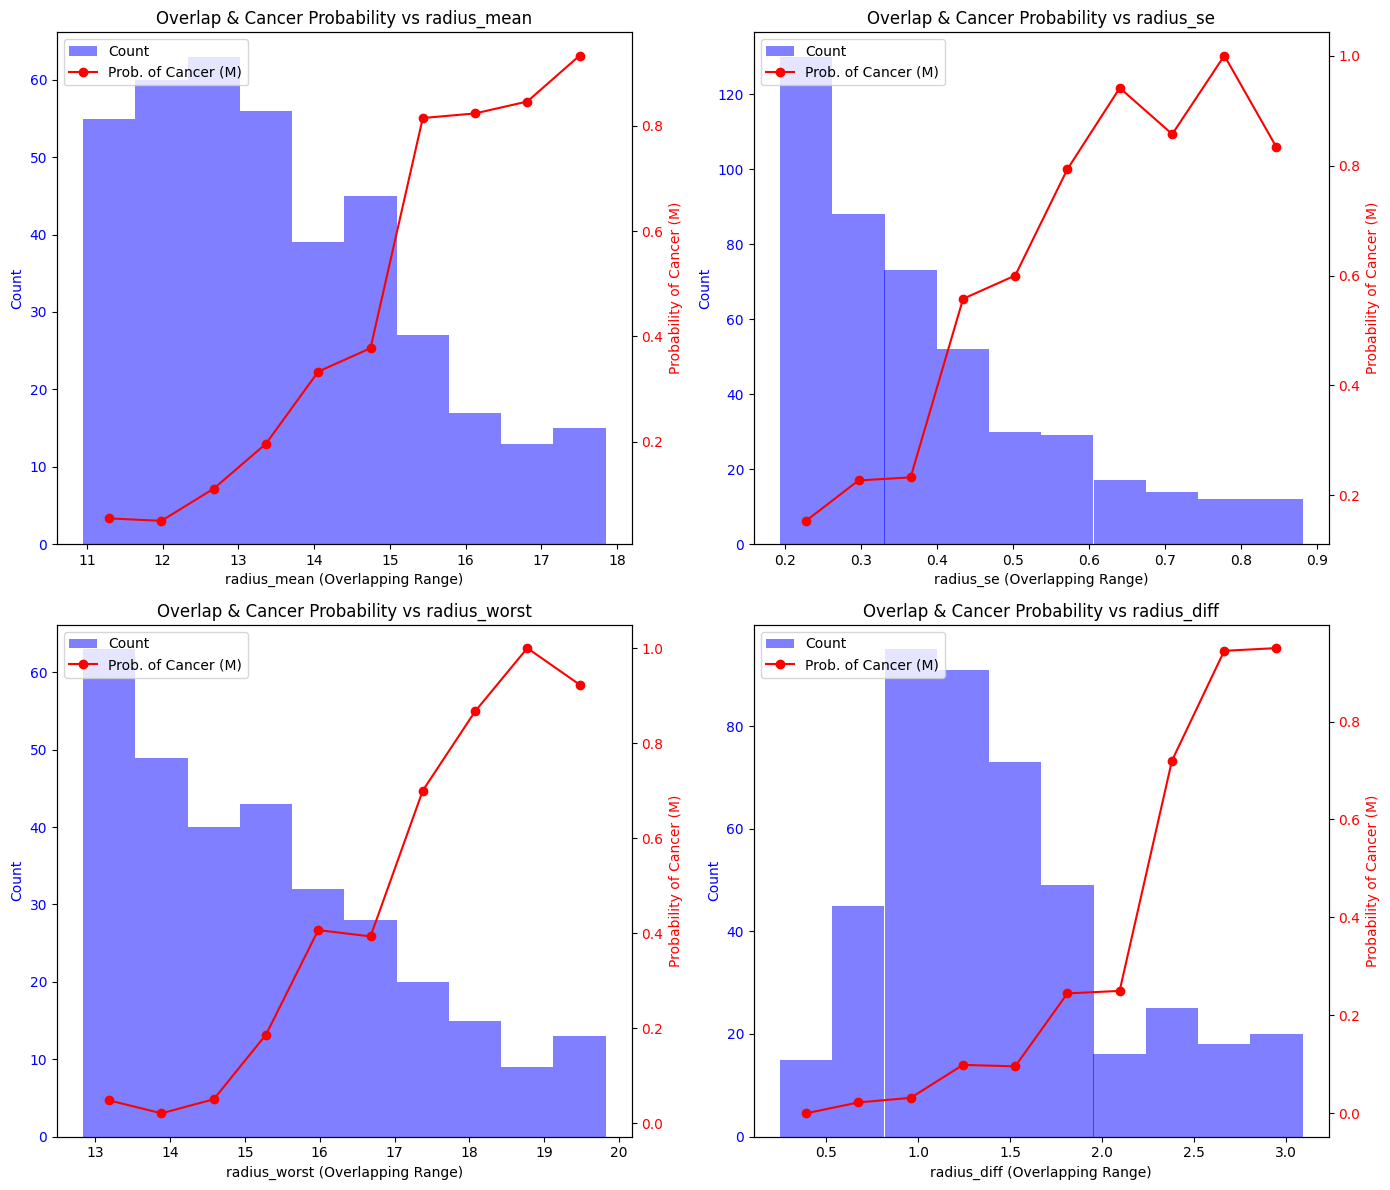

In [6]:
#  2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.flatten()

# loop over each texture variable
for i, var in enumerate(radius_vars):
    
    # determine the overlapping range for the variable
    min_overlap = max(df_M[var].min(), df_B[var].min())
    max_overlap = min(df_M[var].max(), df_B[var].max())
    
    # filter the DataFrame to the overlapping region
    df_overlap = df_rad[(df_rad[var] >= min_overlap) & (df_rad[var] <= max_overlap)].copy()
    
    # create 10 evenly spaced bins in the overlapping range
    bins = np.linspace(min_overlap, max_overlap, 11)
    df_overlap[var + '_bin'] = pd.cut(df_overlap[var], bins=bins, include_lowest=True)
    
    # calculate counts for each bin and the probability of diagnosis "M"
    bin_counts = df_overlap.groupby(var + '_bin')['diagnosis'].count()
    prob_cancer = df_overlap.groupby(var + '_bin')['diagnosis'].apply(lambda x: (x == 'M').sum() / len(x))
    print(prob_cancer)

    # calculate bin centers and bin width
    bin_centers = [interval.mid for interval in bin_counts.index.categories]
    bin_width = bins[1] - bins[0]
    
    # plot on the current subplot
    ax = axes[i]
    # histogram (bar chart) for counts on primary y-axis (blue)
    ax.bar(bin_centers, bin_counts, width=bin_width, alpha=0.5, color='blue', label='Count')
    ax.set_xlabel(f"{var} (Overlapping Range)")
    ax.set_ylabel("Count", color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_title(f"Overlap & Cancer Probability vs {var}")
    
    # create a secondary y-axis for the probability curve (red)
    ax2 = ax.twinx()
    ax2.plot(bin_centers, prob_cancer.values, marker='o', linestyle='-', color='red', label='Prob. of Cancer (M)')
    ax2.set_ylabel("Probability of Cancer (M)", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('plots/histo_overlap_radius.png')
plt.show()


## Some conclusions

- probability of having a malignant cancer grows with the increase of the cell radius, where as the sizes that are found for both malignant and benign cancers chances are higher once the differene of mean and worst is crossing 2 units, displaying that any changes of size up to 0.5 units carry no risks and above 3 are malignant.

### Boxplot overview for 4 radius metrics

C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7284\1019249137.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_rad,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7284\1019249137.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_rad,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7284\1019249137.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_rad,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7284\1019249137.py:8: FutureWarning: 

Passing `palette` w

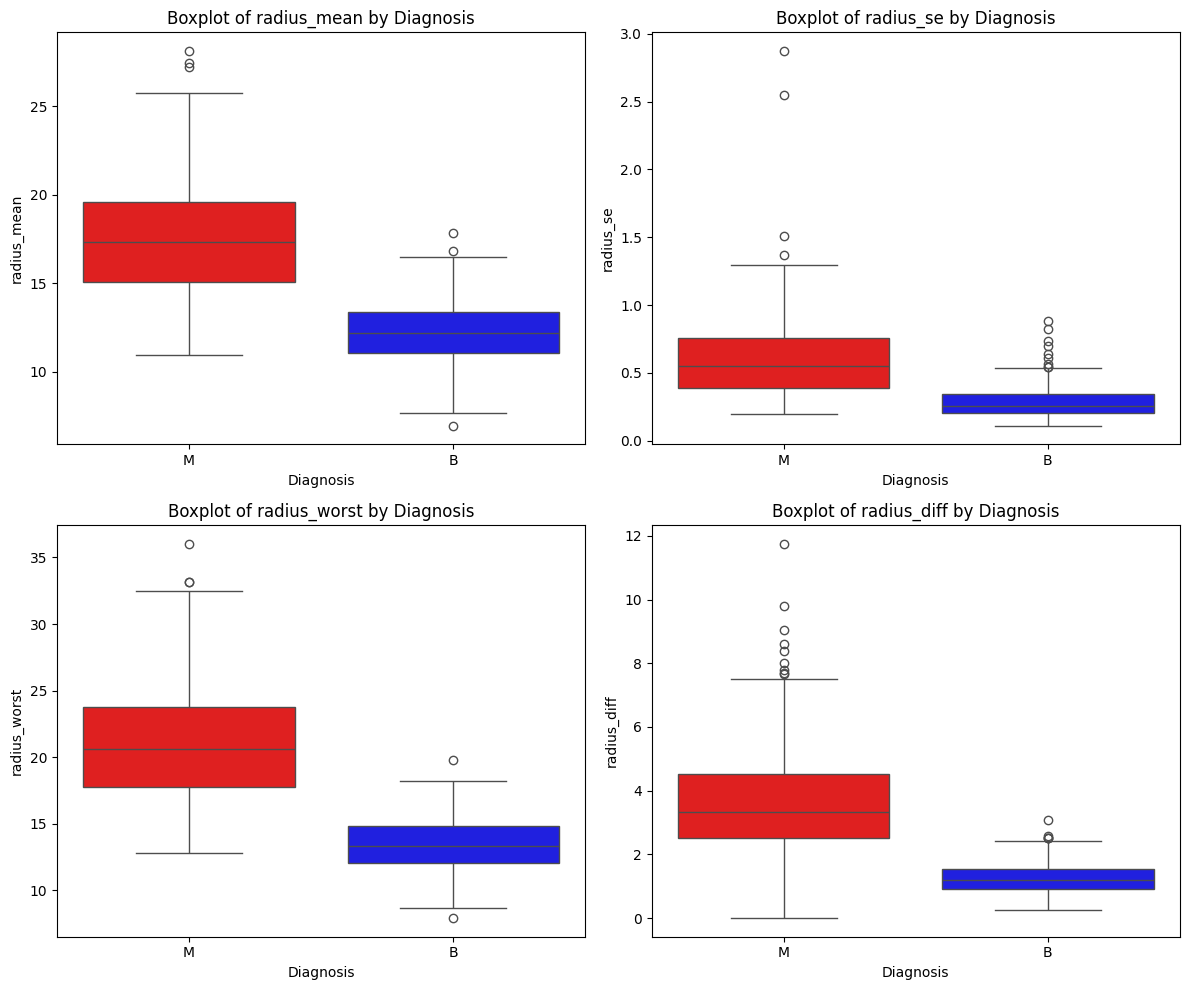

In [7]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # flatten the axes array so each element is an Axes instance

# Loop over each variable and generate a boxplot
for i, var in enumerate(radius_vars):
    ax = axes[i]
    sns.boxplot(x='diagnosis', y=var, data=df_rad,
                palette={'M': 'red', 'B': 'blue'}, ax=ax)
    ax.set_title(f"Boxplot of {var} by Diagnosis")
    ax.set_xlabel("Diagnosis")
    ax.set_ylabel(var)

plt.tight_layout()
plt.savefig('plots/boxplt_radius.png')
plt.show()


### Pearson's correlation for radius_mean, radius_se, radius_worst and radius_diff with diagnosis

In [8]:
df_rad['diagnosis_numeric'] = df_rad['diagnosis'].map({'B': 0, 'M': 1})

# list of radius variables to analyze
radius_columns = ['radius_mean', 'radius_se', 'radius_worst', 'radius_diff']

# dictionary for correlation results
results = {}

for col in radius_columns:
    r, p = pearsonr(df_rad['diagnosis_numeric'], df_rad[col])
    results[col] = {'p-value': p, 'r-Pearson': r}

results_df = pd.DataFrame(results).T
print(results_df)


                    p-value  r-Pearson
radius_mean    8.465941e-96   0.730029
radius_se      9.738949e-50   0.567134
radius_worst  8.482292e-116   0.776454
radius_diff    6.444938e-89   0.711434


all 4 have very small(close to zero) p-values and greater then 0.5 r-Pearson values, indicating very strong positive correlation between radius size and diagnosis

### Chi-Square for the overlapping region for diagnosis and radius at worst

Let's pick the radius_worst metric with the smallest p-value and calculate its Chi-Square p-value.

Since the radius_worst is a continues numeric data, first converting it into discrete values within the overlapping region using binning technique and then calculating p-value of Chi-Square

In [9]:
# determining overlapping range
min_overlap = max(df_M['radius_worst'].min(), df_B['radius_worst'].min())
max_overlap = min(df_M['radius_worst'].max(), df_B['radius_worst'].max())

df_overlap = df_rad[(df_rad['radius_worst'] >= min_overlap) & (df_rad['radius_worst'] <= max_overlap)]

# bins for the overlapping region (10 bins)
bins = np.linspace(min_overlap, max_overlap, 11)
df_overlap = df_overlap.copy()  # avoid SettingWithCopyWarning
df_overlap['radius_bin'] = pd.cut(df_overlap['radius_worst'], bins=bins, include_lowest=True)


contingency_table = pd.crosstab(df_overlap['radius_bin'], df_overlap['diagnosis'])
print(contingency_table)


_,pvalue, _, _ = chi2_contingency(contingency_table)
cramer_v = association(contingency_table, method='cramer')
print(f'Chi-Square p-value is: {pvalue}\nCramer V is: {cramer_v}')


diagnosis          B   M
radius_bin              
(12.839, 13.538]  60   3
(13.538, 14.236]  48   1
(14.236, 14.934]  38   2
(14.934, 15.632]  35   8
(15.632, 16.33]   19  13
(16.33, 17.028]   17  11
(17.028, 17.726]   6  14
(17.726, 18.424]   2  13
(18.424, 19.122]   0   9
(19.122, 19.82]    1  12
Chi-Square p-value is: 1.394378336723893e-26
Cramer V is: 0.679853961429309


extremely small p-value allows us to reject the null hypothesis of independence with high confidence. It shows that there is a statistically significant association between the radius_worst bins and the diagnosis (B vs. M). This means that the distribution of benign ("B") and malignant ("M") cases across the radius_worst intervals is not due to random chance, and the metric radius_worst appears to have a strong relationship with the diagnosis outcome.